In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import quad
from scipy.optimize import minimize
from datetime import datetime as dt

#from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
#from nelson_siegel_svensson.calibrate import calibrate_nss_ols
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Bond Price **Formulas**

In [35]:
def calc_theta_r(kappa, gamma, lambda1,lambda2, sigma1, rho):
  theta_r = (kappa * gamma) - (lambda1 * sigma1 * (1-rho**2)**0.5) - lambda2 * sigma1 * rho
  return theta_r

def calc_theta_h(lambda2, sigma2):
  theta_h = -lambda2 * sigma2
  return theta_h

In [14]:
def calc_br(kappa, tau):
  br = (1 - np.exp(-kappa * tau)) / kappa
  return br

def calc_bh(beta, kappa, tau):
  bh = (1/beta) * (1 - np.exp(-beta * tau)) + (1 / (kappa + beta)) * (np.exp(-kappa * tau) - np.exp(-beta * tau))
  return bh

In [15]:
def calc_alpha(beta, kappa, gamma, lambda1, lambda2, sigma1, sigma2, rho, tau):
  alpha, N = 0, 10000
  dphi=tau/N #dphi is width

  for i in range(1,N):
    # rectangular integration
    phi = dphi * (2*i + 1)/2 # midpoint to calculate height

    theta_r = calc_theta_r(kappa, gamma, lambda1,lambda2, sigma1, rho)
    theta_h = calc_theta_h(lambda2, sigma2)
    br = calc_br(kappa, tau)
    bh = calc_bh(beta, kappa, tau)

    alpha_integral = theta_r * br + theta_h - 0.5 * sigma1**2 + br**2 - rho * sigma1*sigma2 * br * bh - 0.5 * sigma2**2 * bh**2
    #Sum it up
    alpha += dphi * alpha_integral

  return alpha

In [16]:
def hw_bond_price(beta, kappa, gamma, lambda1, lambda2, sigma1, sigma2, rho,r0, h0, tau):
  br = calc_br(kappa, tau)
  bh = calc_bh(beta, kappa, tau)
  alpha = calc_alpha(beta, kappa, gamma, lambda1, lambda2, sigma1, sigma2, rho, tau)

  price = np.exp(-alpha - br * r0 - bh * h0)
  return price

######Old Functions

In [17]:
def heston_charfunc1(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r, q):

  rspi = rho * sigma * phi * 1j
  #Level 1
  b1 = kappa+lambd - rho * sigma
  b2 = kappa+lambd
  u1 = 0.5
  u2= -0.5
  a = kappa * theta

  #Level 2
  d1 = np.sqrt((rspi - b1)**2 - sigma**2 * (2 * u1 * phi * 1j - phi**2))
  d2 = np.sqrt((rspi - b2)**2 - sigma**2 * (2 * u2 * phi * 1j - phi**2))
  g1 = (b1 - rspi + d1) / (b1 - rspi - d1)
  g2 = (b2 - rspi + d2) / (b2 - rspi - d2)

  #Level 3
  C1 = (r-q) * phi * 1j * tau + ((kappa * theta)/(sigma**2)) * ((b1 - rspi + d1)*tau - 2 * np.log((1-g1*np.exp(d1*tau))/(1-g1)))
  C2 = (r-q) * phi * 1j * tau + ((kappa * theta)/(sigma**2)) * ((b2 - rspi + d2)*tau - 2 * np.log((1-g2*np.exp(d2*tau))/(1-g2)))
  D1 = ((b1 - rspi + d1)/(sigma**2)) * ((1- np.exp(d1 * tau))/(1- g1 * np.exp(d1 * tau)))
  D2 = ((b2 - rspi + d2)/(sigma**2)) * ((1- np.exp(d2 * tau))/(1- g2 * np.exp(d2 * tau)))

  charc1 = np.exp(C1 + D1*v0 + 1j * phi * S0)
  charc2 = np.exp(C2 + D2*v0 + 1j * phi * S0)

  return charc1

In [18]:
def heston_charfunc2(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r, q):

  rspi = rho * sigma * phi * 1j
  #Level 1
  b1 = kappa+lambd - rho * sigma
  b2 = kappa+lambd
  u1 = 0.5
  u2= -0.5
  a = kappa * theta

  #Level 2
  d1 = np.sqrt((rspi - b1)**2 - sigma**2 * (2 * u1 * phi * 1j - phi**2))
  d2 = np.sqrt((rspi - b2)**2 - sigma**2 * (2 * u2 * phi * 1j - phi**2))
  g1 = (b1 - rspi + d1) / (b1 - rspi -d1)
  g2 = (b2 - rspi + d2) / (b2 - rspi -d2)

  #Level 3
  C1 = (r-q) * phi * 1j * tau + ((kappa * theta)/(sigma**2)) * ((b1 - rspi + d1)*tau - 2 * np.log((1-g1*np.exp(d1*tau))/(1-g1)))
  C2 = (r-q) * phi * 1j * tau + ((kappa * theta)/(sigma**2)) * ((b2 - rspi + d2)*tau - 2 * np.log((1-g2*np.exp(d2*tau))/(1-g2)))
  D1 = ((b1 - rspi + d1)/(sigma**2)) * ((1- np.exp(d1 * tau))/(1- g1 * np.exp(d1 * tau)))
  D2 = ((b2 - rspi + d2)/(sigma**2)) * ((1- np.exp(d2 * tau))/(1- g2 * np.exp(d2 * tau)))

  charc1 = np.exp(C1 + D1*v0 + 1j * phi * S0)
  charc2 = np.exp(C2 + D2*v0 + 1j * phi * S0)

  return charc2

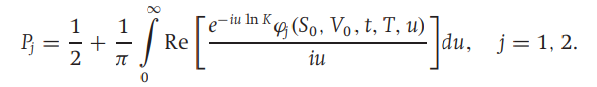

In [19]:
def integrand1(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r, q):
  args = (np.log(S0), v0, kappa, theta, sigma, rho, lambd, tau, r, q)
  numerator = np.exp(-1 * 1j * phi *np.log(K))*heston_charfunc1(phi,*args)
  denominator = 1j*phi
  return numerator/denominator

def integrand2(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r, q):
  args = (np.log(S0), v0, kappa, theta, sigma, rho, lambd, tau, r, q)
  numerator = np.exp(-1 * 1j * phi *np.log(K))*heston_charfunc2(phi,*args)
  denominator = 1j*phi
  return numerator/denominator

In [20]:
def heston_price_BF_alt(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r, q):
  args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r, q)
  P1_integral, err1 = np.real( quad(integrand1, 0, 100, args=args) )
  P1 = 0.5 + (1 / np.pi)  * P1_integral

  P2_integral, err2 = np.real( quad(integrand2, 0, 100, args=args) )
  P2 = 0.5 + (1 / np.pi)  * P2_integral

  call_price = S0 * P1 - K * np.exp(-(r-q)*tau)*P2
  return call_price

In [21]:
def heston_price_BF(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r, q):
  args = (np.log(S0), v0, kappa, theta, sigma, rho, lambd, tau, r, q)

  P1_integral, umax, N = 0, 100, 10000
  dphi=umax/N #dphi is width

  for i in range(1,N):
    # rectangular integration
    phi = dphi * (2*i + 1)/2 # midpoint to calculate height
    numerator = np.exp(-1 * 1j * phi *np.log(K))*heston_charfunc1(phi,*args)
    denominator = 1j*phi
    #Sum it up
    P1_integral += dphi * numerator/denominator

  P2_integral, umax, N = 0, 100, 10000
  dphi=umax/N #dphi is width

  for i in range(1,N):
    # rectangular integration
    phi = dphi * (2*i + 1)/2 # midpoint to calculate height
    numerator = np.exp(-1 * 1j * phi *np.log(K))*heston_charfunc2(phi,*args)
    denominator = 1j*phi
    #Sum it up
    P2_integral += dphi * numerator/denominator

  P1 = 0.5 + (1 / np.pi)  * P1_integral
  P2 = 0.5 + (1 / np.pi)  * P2_integral

  call_price = np.real(S0 * P1 - K * np.exp(-(r-q)*tau)*P2)
  return call_price

In [22]:
# Parameters to test model






###German Government Bond **Calibration**

In [ ]:
beta = 0.1
kappa = 0.5
gamma = 0.1
lambda1 = -0.05
lambda2 = -0.05
sigma1 = 0.025
sigma2 = 0.02
rho = -0.5
h0 = 0.2
r0 = 0.027
tau = 10

bond_price = hw_bond_price(beta, kappa, gamma, lambda1, lambda2, sigma1, sigma2, rho,r0, h0, tau)
bond_price

np.float64(8.336756640109998e-19)

Import data

In [ ]:
path="/content/drive/MyDrive/Master thesis/Interest_rate_data/zero_bond_prices.xlsx"
sheet_name= "paneldata"
df_bond_prices =pd.read_excel(path,sheet_name)
df_bond_prices

In [36]:
r0 = df_bond_prices['euribor1m'].to_numpy('float')
tau = df_bond_prices['maturity'].to_numpy('float')
P = df_bond_prices['price'].to_numpy('float')

params = {"h0": {"x0": 0.03, "lbub": [-1,1]},
          "kappa": {"x0": 1, "lbub": [1e-3,5]},
          "gamma": {"x0": 0.03, "lbub": [-1,1]},
          "sigma1": {"x0": 0.02, "lbub": [1e-2,0.2]},
          "sigma2": {"x0": 0.05, "lbub": [1e-2,1]},
          "rho": {"x0": -0.8, "lbub": [-1,1]},
          "lambda1": {"x0": -0.05, "lbub": [-1,0]},
          "lambda2": {"x0": -0.05, "lbub": [-1,0]},
          "beta": {"x0": 0.05, "lbub": [-1,1]},
          }

x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]

def SqErr(x):
    h0, kappa, gamma, sigma1,sigma2, rho, lambda1, lambda2,beta = [param for param in x]

    # Rectengular integreation
    err = np.sum( (P-hw_bond_price(beta, kappa, gamma, lambda1, lambda2, sigma1, sigma2, rho,r0, h0, tau))**2 /len(P) )

    # Zero penalty term - no good guesses for parameters
    pen = 0

    return err + pen

In [ ]:
result = minimize(SqErr, x0, tol = 1e-3, method='SLSQP', options={'maxiter': 1e4 }, bounds=bnds)
result

In [38]:
h0, kappa, gamma, sigma1,sigma2, rho, lambda1,lambda2, beta = [param for param in result.x]
print(f"h0: {h0}")
print(f"kappa: {kappa}")
print(f"gamma: {gamma}")
print(f"sigma1: {sigma1}")
print(f"sigma2: {sigma2}")
print(f"rho: {rho}")
print(f"lambda1: {lambda1}")
print(f"lambda2: {lambda2}")
print(f"beta: {beta}")

h0: -0.9999998770467248
kappa: 4.999337700205912
gamma: -0.21893737324740867
sigma1: 0.010025186989007319
sigma2: 0.010000066523395912
rho: -0.9998353041461688
lambda1: -0.9998675864737375
lambda2: -1.433413829768022e-08
beta: 0.3103330099703502


In [39]:
model_bond_prices = hw_bond_price(beta, kappa, gamma, lambda1, lambda2, sigma1, sigma2, rho,r0, h0, tau)
df_bond_prices['heston_price'] = model_bond_prices
df_bond_prices

,date,maturity,euribor1m,price,heston_price
0,1998-12-30,1,0.03258,97.030856,2.445911
1,1999-01-04,1,0.03242,97.068530,2.445989
2,1999-01-05,1,0.03233,97.096806,2.446033
3,1999-01-06,1,0.03226,97.096806,2.446067
4,1999-01-07,1,0.03224,97.115665,2.446077
...,...,...,...,...,...
69565,2025-02-17,10,0.02616,77.891564,128.675788
69566,2025-02-18,10,0.02624,77.815636,128.673729
69567,2025-02-19,10,0.02641,77.664022,128.669354
69568,2025-02-20,10,0.02653,77.437211,128.666265


###3 Factor **CIR**

In [ ]:
def f_function():
  c = calc_c(kappa,sigma,delta_t)
  q = calc_q(kappa, theta, sigma)
  component1 = c * np.exp(-c * y_t - c * np.exp(-kappa * delta_t) * y_t_minus1)
  component2 = (y_t / (y_t_minus1 * np.exp(-kappa * delta_t)))** (0.5 * q)
  internal_arguemnt =


  return f

def calc_c(kappa,sigma,delta_t):
  denumerator = 2 * kappa
  numerator = sigma**2 * (1 - np-exp(kappa * delta_t))
  c = denumerator / numerator
  return c

def calc_q(kappa, theta, sigma):
  q = ((2 * kappa * theta) / sigma**2 ) -1
  return q



